## Time Series Analysis Models - LSTM

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
data = yf.Ticker('GOOG')
data = data.history(period= 'max')
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2004-08-19 00:00:00-04:00,2.490664,2.591785,2.390042,2.499133,897427216,0.0,0.0
2004-08-20 00:00:00-04:00,2.515820,2.716817,2.503118,2.697639,458857488,0.0,0.0
2004-08-23 00:00:00-04:00,2.758411,2.826406,2.716070,2.724787,366857939,0.0,0.0
2004-08-24 00:00:00-04:00,2.770615,2.779581,2.579581,2.611960,306396159,0.0,0.0
2004-08-25 00:00:00-04:00,2.614201,2.689918,2.587302,2.640104,184645512,0.0,0.0
...,...,...,...,...,...,...,...
2023-05-25 00:00:00-04:00,125.209999,125.980003,122.900002,124.349998,33812700,0.0,0.0
2023-05-26 00:00:00-04:00,124.065002,126.000000,123.290001,125.430000,25154700,0.0,0.0
2023-05-30 00:00:00-04:00,126.290001,126.379997,122.889999,124.639999,27230700,0.0,0.0


In [3]:
df = data.copy()

In [4]:
data['Last Day Closing Price'] = data['Close'].shift(1)
data['Closing Change'] = data['Close'] - data['Last Day Closing Price']

data.drop(['Dividends', 'Stock Splits', 'Last Day Closing Price'], axis= 1, inplace= True)
data

,Open,High,Low,Close,Volume,Closing Change
Date,,,,,,
2004-08-19 00:00:00-04:00,2.490664,2.591785,2.390042,2.499133,897427216,NaN
2004-08-20 00:00:00-04:00,2.515820,2.716817,2.503118,2.697639,458857488,0.198506
2004-08-23 00:00:00-04:00,2.758411,2.826406,2.716070,2.724787,366857939,0.027148
2004-08-24 00:00:00-04:00,2.770615,2.779581,2.579581,2.611960,306396159,-0.112827
2004-08-25 00:00:00-04:00,2.614201,2.689918,2.587302,2.640104,184645512,0.028144
...,...,...,...,...,...,...
2023-05-25 00:00:00-04:00,125.209999,125.980003,122.900002,124.349998,33812700,2.709999
2023-05-26 00:00:00-04:00,124.065002,126.000000,123.290001,125.430000,25154700,1.080002
2023-05-30 00:00:00-04:00,126.290001,126.379997,122.889999,124.639999,27230700,-0.790001


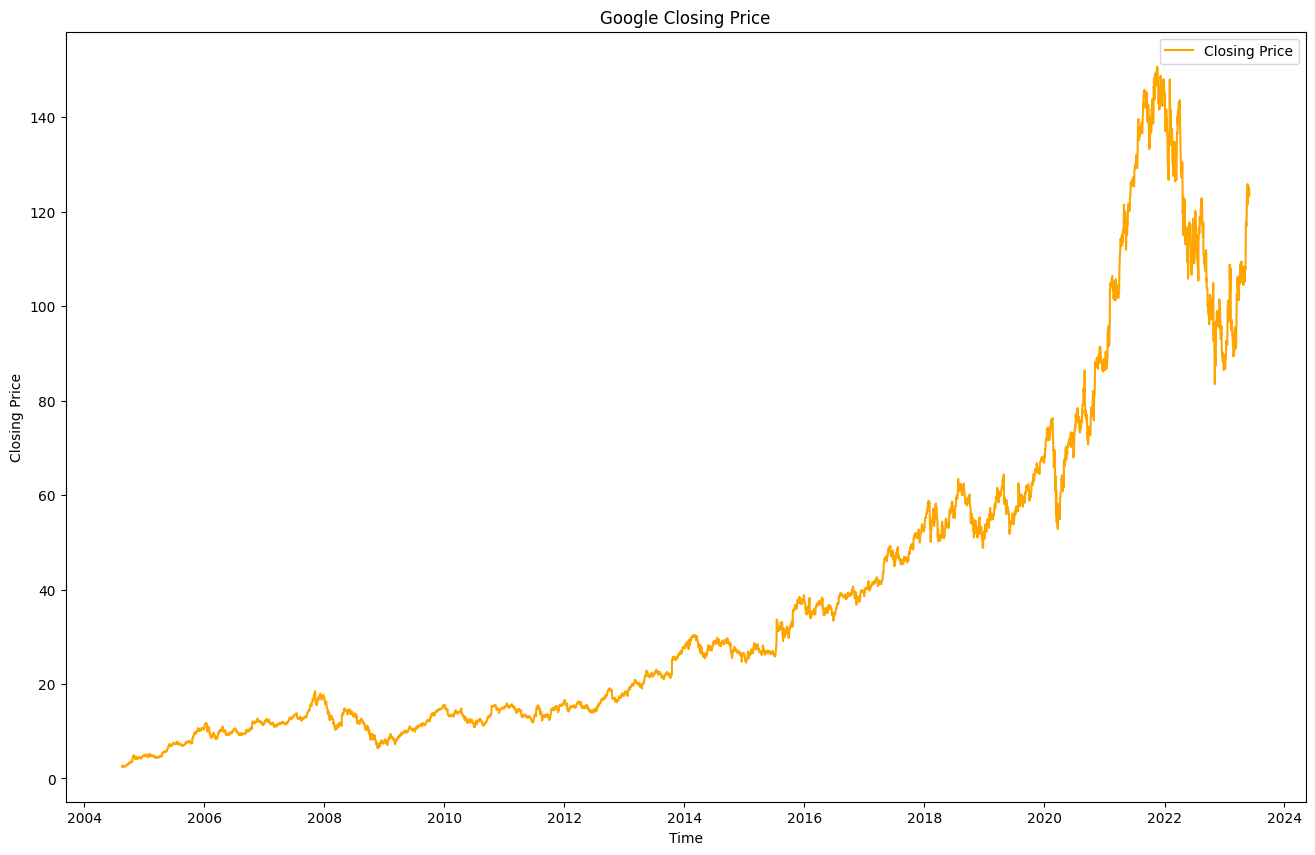

In [5]:
plt.figure(figsize= (16,10))
plt.title('Google Closing Price')
plt.plot(data['Close'], color= 'orange', label= 'Closing Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

We can see that the closing price of Google has witnessed a greater increase after 2015 as compared to the preceding years. Thus, I'm selecting the data from 2015 to put in the model.

In [6]:
# Find the earliest dates that the Google stock market opens in 2015
data = data.reset_index()
data[data['Date'].dt.strftime('%Y').str.contains('2015')]

,Date,Open,High,Low,Close,Volume,Closing Change
2611,2015-01-02 00:00:00-05:00,26.378078,26.490770,26.133251,26.168653,28951268,-0.079283
2612,2015-01-05 00:00:00-05:00,26.091366,26.144720,25.582764,25.623152,41196796,-0.545502
2613,2015-01-06 00:00:00-05:00,25.679497,25.738087,24.983908,25.029282,57998800,-0.593870
2614,2015-01-07 00:00:00-05:00,25.280592,25.292759,24.914099,24.986401,41301082,-0.042881
2615,2015-01-08 00:00:00-05:00,24.831326,25.105074,24.482782,25.065184,67071641,0.078783
...,...,...,...,...,...,...,...
2858,2015-12-24 00:00:00-05:00,37.477501,37.567501,37.331001,37.419998,10544000,-0.095501
2859,2015-12-28 00:00:00-05:00,37.646000,38.149502,37.476002,38.125500,30306000,0.705502
2860,2015-12-29 00:00:00-05:00,38.334499,38.999001,38.321499,38.830002,35300000,0.704502
2861,2015-12-30 00:00:00-05:00,38.830002,38.880001,38.345001,38.549999,25866000,-0.280003


With this model, I'm going to use a window size of 30, so I will use data from 2015 + previous 30 days

In [7]:
# Select data from 2015 until the most recent one, along with the previous 30 days
data = data.loc[2581:]
data

,Date,Open,High,Low,Close,Volume,Closing Change
2581,2014-11-18 00:00:00-05:00,26.801416,27.022808,26.635372,26.678255,39253475,-0.073797
2582,2014-11-19 00:00:00-05:00,26.676760,26.838314,26.431433,26.775988,27844237,0.097733
2583,2014-11-20 00:00:00-05:00,26.489773,26.682243,26.481297,26.668282,31267610,-0.107706
2584,2014-11-21 00:00:00-05:00,27.006353,27.032782,26.754545,26.801416,44485801,0.133135
2585,2014-11-24 00:00:00-05:00,26.808895,27.060705,26.707674,26.889673,34127440,0.088257
...,...,...,...,...,...,...,...
4724,2023-05-25 00:00:00-04:00,125.209999,125.980003,122.900002,124.349998,33812700,2.709999
4725,2023-05-26 00:00:00-04:00,124.065002,126.000000,123.290001,125.430000,25154700,1.080002
4726,2023-05-30 00:00:00-04:00,126.290001,126.379997,122.889999,124.639999,27230700,-0.790001
4727,2023-05-31 00:00:00-04:00,123.699997,124.900002,123.099998,123.370003,41548800,-1.269997


### LSTM for Closing Price

In [8]:
# Scale data
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_close = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
scaled_close

array([[0.01679115],
       [0.01756588],
       [0.01671208],
       ...,
       [0.79334743],
       [0.78327999],
       [0.79120713]])

In [9]:
scaled_close.shape

(2148, 1)

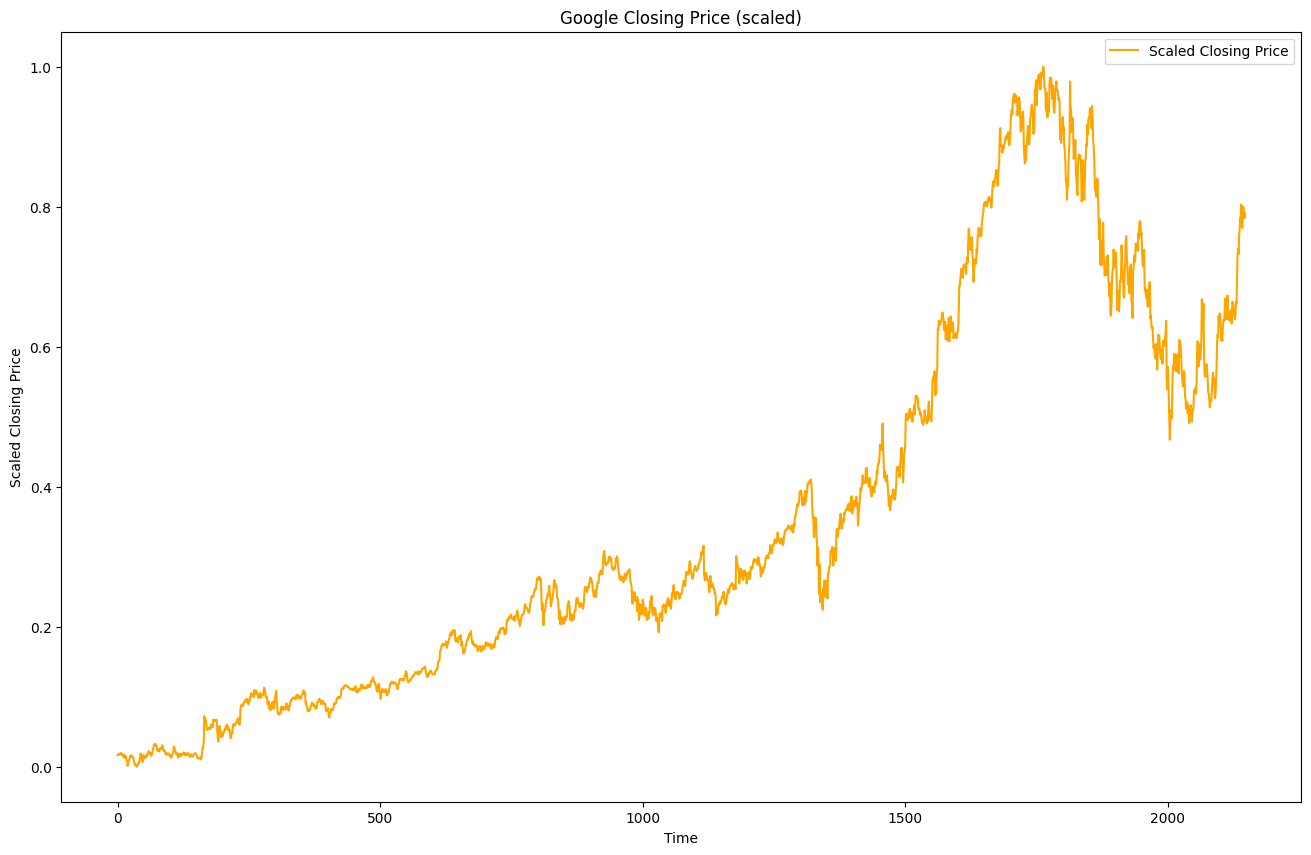

In [10]:
plt.figure(figsize= (16,10))
plt.title('Google Closing Price (scaled)')
plt.plot(scaled_close, color= 'orange', label= 'Scaled Closing Price')
plt.xlabel('Time')
plt.ylabel('Scaled Closing Price')
plt.legend()
plt.show()

In [11]:
# Split data into train and test data
train_close, test_close = train_test_split(scaled_close, test_size= 0.2, shuffle= False)

In [12]:
# Create a function to create input sequences for LSTM
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 30

# Create input sequences for testing data
X_train_close, y_train_close = create_sequences(train_close, seq_length)
X_test_close, y_test_close = create_sequences(test_close, seq_length)

# Discard first 30 sequences of training data
X_train_close = X_train_close[31:,:]
y_train_close = y_train_close[31:,]

In [13]:
# Create and fit the model
model_close = Sequential()
model_close.add(LSTM(50, return_sequences= True, input_shape= (X_train_close.shape[1], 1)))
model_close.add(Dropout(0.2))
model_close.add(LSTM(50, return_sequences= True))
model_close.add(LSTM(50))
model_close.add(Dense(1))

model_close.compile(loss= 'mean_squared_error', optimizer= 'adam')
model_close.fit(X_train_close, y_train_close, epochs= 100, batch_size= 32)

Epoch 1/100
52/52 [==============================] - 19s 49ms/step - loss: 0.0062
Epoch 2/100
52/52 [==============================] - 2s 46ms/step - loss: 5.6445e-04
Epoch 3/100
52/52 [==============================] - 2s 48ms/step - loss: 5.0844e-04
Epoch 4/100
52/52 [==============================] - 2s 47ms/step - loss: 5.3995e-04
Epoch 5/100
52/52 [==============================] - 2s 45ms/step - loss: 4.8672e-04
Epoch 6/100
52/52 [==============================] - 2s 47ms/step - loss: 5.0173e-04
Epoch 7/100
52/52 [==============================] - 3s 58ms/step - loss: 4.8821e-04
Epoch 8/100
52/52 [==============================] - 3s 65ms/step - loss: 5.2620e-04
Epoch 9/100
52/52 [==============================] - 3s 55ms/step - loss: 4.7409e-04
Epoch 10/100
52/52 [==============================] - 3s 53ms/step - loss: 4.6992e-04
Epoch 11/100
52/52 [==============================] - 3s 56ms/step - loss: 4.4831e-04
Epoch 12/100
52/52 [==============================] - 3s 55ms/step

In [14]:
y_pred_close = model_close.predict(X_test_close)
y_pred_close = scaler.inverse_transform(y_pred_close)
y_test_close = scaler.inverse_transform(y_test_close.reshape(-1, 1))

13/13 [==============================] - 3s 17ms/step


In [15]:
# Evaluate the model
mse_close = mean_squared_error(y_test_close, y_pred_close)
rmse_close = sqrt(mse_close)
r2_score_close = r2_score(y_test_close, y_pred_close)
print('RMSE of LSTM model for closing price:', rmse_close, '\nR2 Score of LSTM model for closing price:', r2_score_close)

RMSE of LSTM model for closing price: 3.057429794769152 
R2 Score of LSTM model for closing price: 0.972300224978198


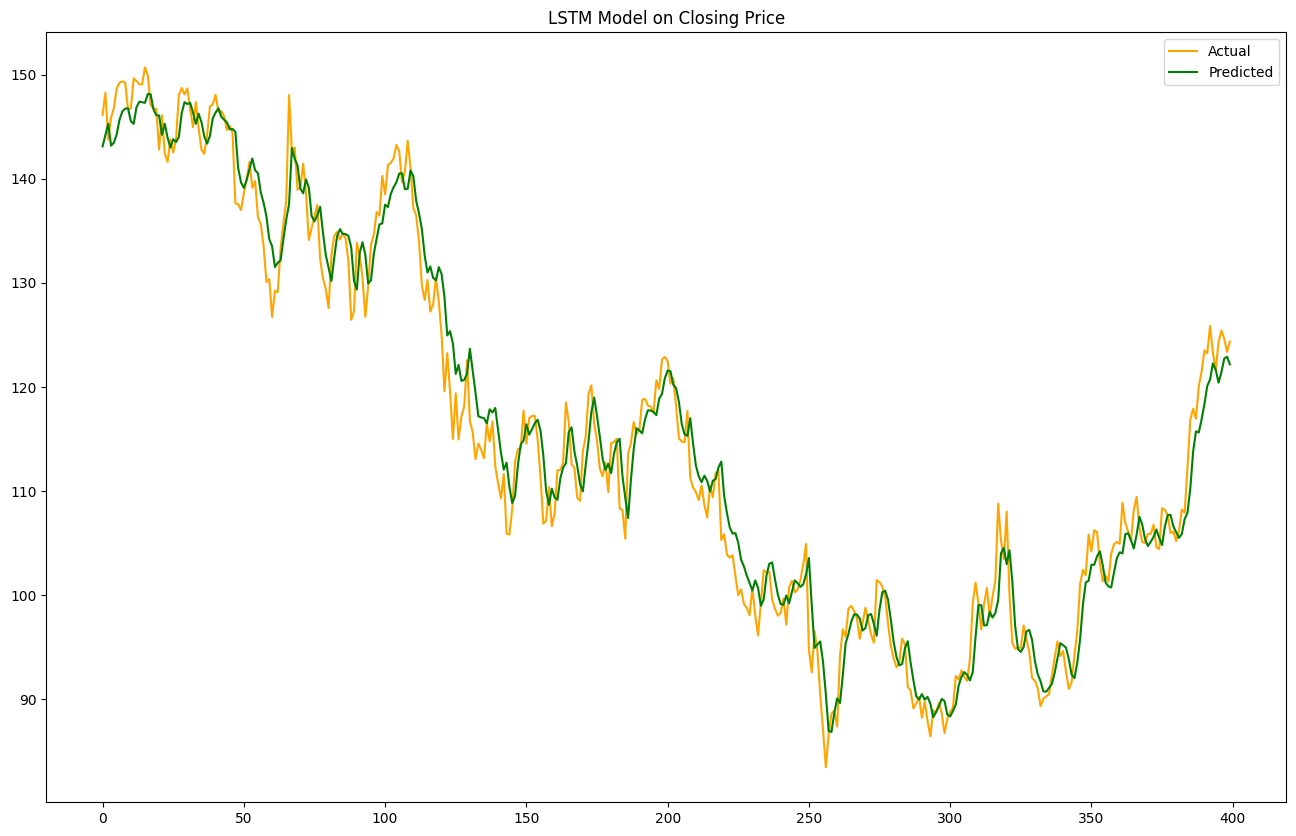

In [16]:
# Plot the prediction and real data
plt.figure(figsize= (16,10))
plt.title('LSTM Model on Closing Price')
plt.plot(y_test_close, color= 'orange', label= 'Actual')
plt.plot(y_pred_close, color= 'green', label= 'Predicted')
plt.legend()
plt.show()

In [17]:
# Compare test data and the prediction
y_test_close = y_test_close.flatten()
y_pred_close = y_pred_close.flatten()
close_data_test = pd.DataFrame({'Closing Price (Test Data)': y_test_close, 'Closing Price (Prediction on Test Data)': y_pred_close, 'Difference': np.abs(y_test_close - y_pred_close)})
close_data_test

,Closing Price (Test Data),Closing Price (Prediction on Test Data),Difference
0,146.128998,143.115311,3.013687
1,148.270493,144.227066,4.043427
2,143.774002,145.295059,1.521057
3,145.863007,143.183945,2.679062
4,146.789993,143.462769,3.327225
...,...,...,...
395,124.349998,120.420708,3.929291
396,125.430000,121.400688,4.029312
397,124.639999,122.730125,1.909874
398,123.370003,122.912056,0.457947


### LSTM for Closing Price Change

In [18]:
# Scale data
scaler = MinMaxScaler(feature_range= (0,1))
scaled_change = scaler.fit_transform(data['Closing Change'].values.reshape(-1, 1))
scaled_change

array([[0.4951747 ],
       [0.50363778],
       [0.49350167],
       ...,
       [0.45983803],
       [0.4361556 ],
       [0.54815461]])

In [19]:
scaled_change.shape

(2148, 1)

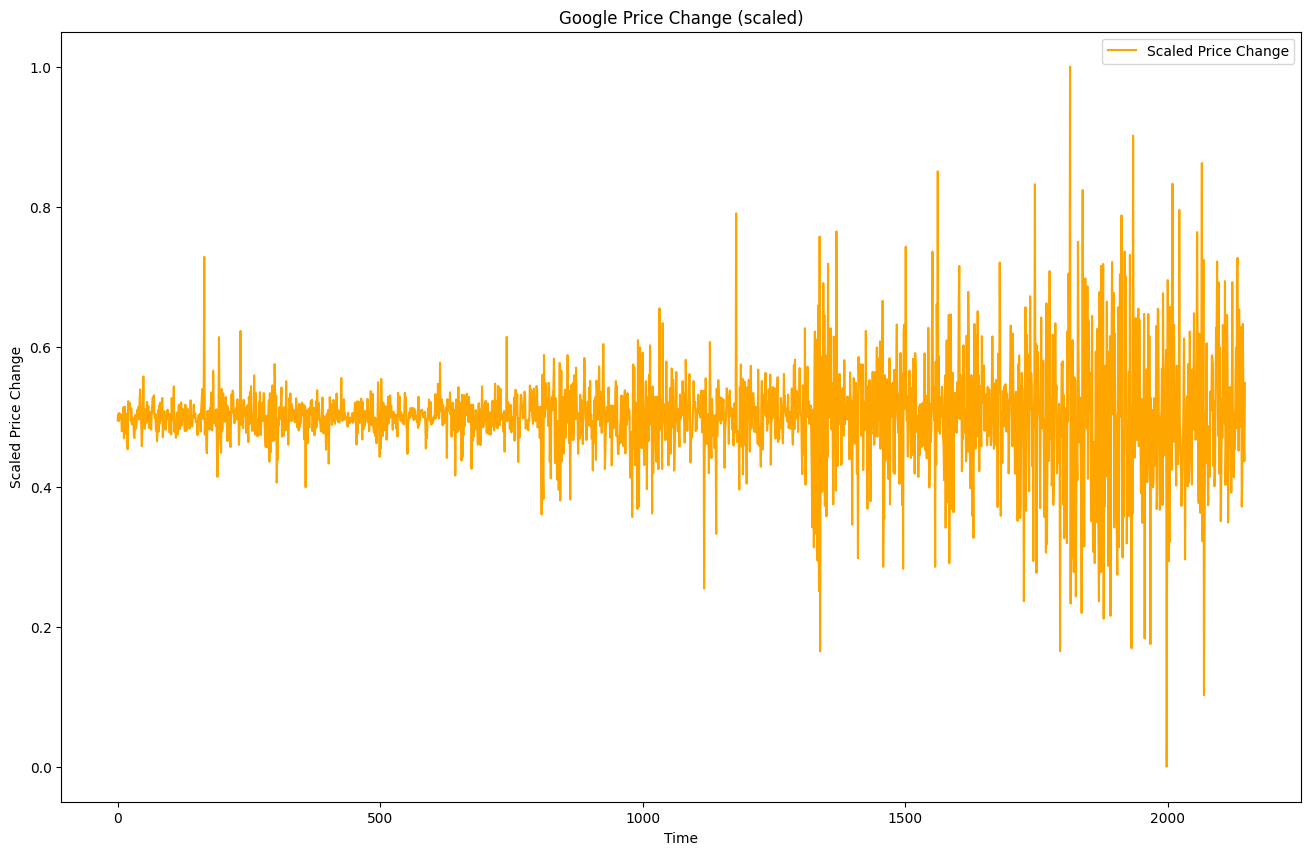

In [20]:
plt.figure(figsize= (16,10))
plt.title('Google Price Change (scaled)')
plt.plot(scaled_change, color= 'orange', label= 'Scaled Price Change')
plt.xlabel('Time')
plt.ylabel('Scaled Price Change')
plt.legend()
plt.show()

In [21]:
# Split data into train and test data
train_change, test_change = train_test_split(scaled_change, test_size= 0.2, shuffle= False)

In [22]:
# Create a function to create input sequences for LSTM
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 30
# Create input sequences for testing data
X_train_change, y_train_change = create_sequences(train_change, seq_length)
X_test_change, y_test_change = create_sequences(test_change, seq_length)
# Discard first 30 sequences of training data
X_train_change = X_train_change[31:,:]
y_train_change = y_train_change[31:,]

In [23]:
# Create and fit the model
model_change = Sequential()
model_change.add(LSTM(50, return_sequences = True, input_shape= (X_train_change.shape[1], 1)))
model_change.add(LSTM(50, return_sequences = True))
model_change.add(LSTM(50))
model_change.add(Dense(1))

model_change.compile(loss='mean_squared_error', optimizer= 'adam')
model_change.fit(X_train_change, y_train_change, epochs= 100, batch_size= 32)

Epoch 1/100
52/52 [==============================] - 16s 67ms/step - loss: 0.0204
Epoch 2/100
52/52 [==============================] - 3s 57ms/step - loss: 0.0027
Epoch 3/100
52/52 [==============================] - 3s 60ms/step - loss: 0.0027
Epoch 4/100
52/52 [==============================] - 3s 55ms/step - loss: 0.0026
Epoch 5/100
52/52 [==============================] - 3s 57ms/step - loss: 0.0027
Epoch 6/100
52/52 [==============================] - 2s 48ms/step - loss: 0.0027
Epoch 7/100
52/52 [==============================] - 2s 48ms/step - loss: 0.0027
Epoch 8/100
52/52 [==============================] - 3s 57ms/step - loss: 0.0027
Epoch 9/100
52/52 [==============================] - 3s 60ms/step - loss: 0.0027
Epoch 10/100
52/52 [==============================] - 3s 49ms/step - loss: 0.0028
Epoch 11/100
52/52 [==============================] - 2s 48ms/step - loss: 0.0027
Epoch 12/100
52/52 [==============================] - 2s 47ms/step - loss: 0.0026
Epoch 13/100
52/52 [====

In [24]:
y_pred_change = model_change.predict(X_test_change)
y_pred_change = scaler.inverse_transform(y_pred_change)
y_test_change = scaler.inverse_transform(y_test_change.reshape(-1, 1))

13/13 [==============================] - 2s 13ms/step


In [25]:
# Evaluate the mode
mse_change = mean_squared_error(y_test_change, y_pred_change)
rmse_change = sqrt(mse_change)
r2_score_change = r2_score(y_test_change, y_pred_change)
print('RMSE of LSTM model for price change:', rmse_change, '\nR2 Score of LSTM model for price change:', r2_score_change)

RMSE of LSTM model for price change: 2.5966692529429634 
R2 Score of LSTM model for price change: -0.01510390221275304


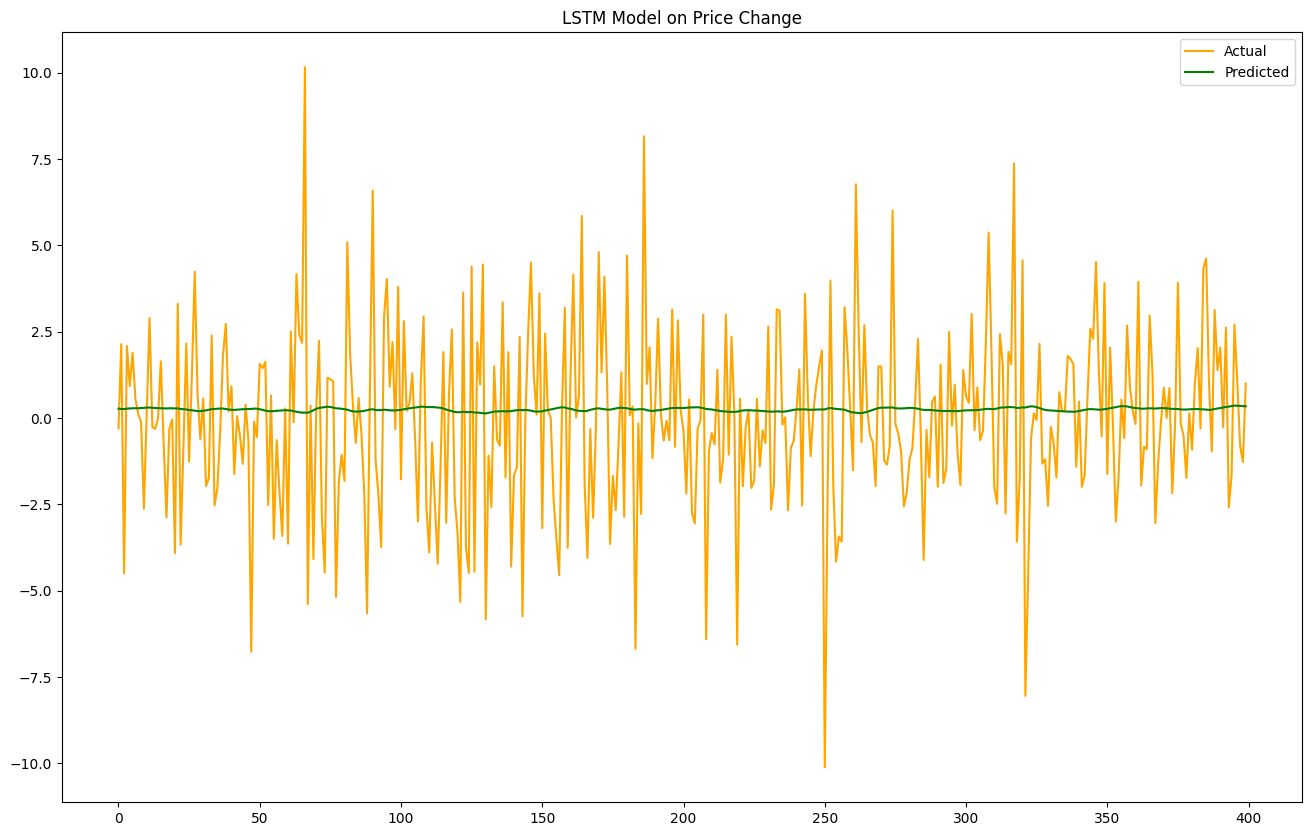

In [26]:
# Plot the prediction and real data
plt.figure(figsize= (16,10))
plt.title('LSTM Model on Price Change')
plt.plot(y_test_change, color= 'orange', label= 'Actual')
plt.plot(y_pred_change, color= 'green', label= 'Predicted')
plt.legend()
plt.show()

In [27]:
# Compare test data and the prediction
y_test_change = y_test_change.flatten()
y_pred_change = y_pred_change.flatten()
change_data_test = pd.DataFrame({'Price Change (Test Data)': y_test_change, 'Price Change (Prediction on Test Data)': y_pred_change})
change_data_test

,Price Change (Test Data),Price Change (Prediction on Test Data)
0,-0.298508,0.272906
1,2.141495,0.264639
2,-4.496490,0.260370
3,2.089005,0.275140
4,0.926987,0.280683
...,...,...
395,2.709999,0.362216
396,1.080002,0.359385
397,-0.790001,0.352120
398,-1.269997,0.346914
